### Notebook for the label transfer of Healthy Human Reference to mouse ACM heart (merged Pkp2+Ttn dataset) using `scANVI`

### T-cells only

#### Environment: scANVI

- **Developed by:** Carlos Talavera-López Ph.D
- **Modified by:** Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 230918
- **Date of modification:** 240226

Yoshida PBMC dataset (subsetted to contain only healthy donors) and healthy human heart leucocytes (from Human cell atlas) were combined to generate a reference for seed labelling

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
#from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 9.4.0
absl                NA
asttokens           NA
attr                23.2.0
chex                0.1.85
colorama            0.4.6
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.0
executing           2.0.1
flax                0.8.1
fsspec              2024.2.0
h5py                3.10.0
importlib_resources NA
ipykernel           6.29.2
ipywidgets          8.1.2
jax                 0.4.24
jaxlib              0.4.24
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
mizani              0.9.3
ml_collections      NA
ml_dtypes           0.3.2
mpl_toolkits        NA
msgpack          

In [3]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [4]:
torch.set_float32_matmul_precision('high')

In [5]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [6]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [7]:
#Merged Healthy reference = Yoshida_PBMC_data_from_healthy_human_donors + Human_Cell_Atlas_Cardiac_leucocytes_from_healthy_human_donors

reference = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/Merged_healthy_reference_PBMC_Heart_ac240222.raw.h5ad')
reference

AnnData object with n_obs × n_vars = 214552 × 33514
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels'
    var: 'name-Yoshida'

In [8]:
X_is_raw(reference)

True

In [9]:
reference.obs['seed_annotation_general'] = reference.obs['seed_labels'].copy()          #store general seed labels in new column to later fill in the specific seed labels in 'seed_labels'

In [10]:
reference.obs['seed_annotation_general'].cat.categories

Index(['B_cells', 'Baso_Eosino', 'CD4+T', 'CD8+T', 'DC', 'Doublets',
       'Hematopoetic', 'ILC', 'Macrophages', 'Mast_cells', 'Monocytes', 'NK',
       'NKT', 'Neutrophils', 'Plasma_cells', 'Platelets', 'Treg', 'pDC'],
      dtype='object')

In [11]:
del(reference.obs['seed_labels'])
reference.obs['seed_labels'] = reference.obs['cell_states'].copy()              #delete existing 'seed_labels' and create new 'seed_labels' with the specific cell states


In [12]:
reference.obs['seed_labels'].value_counts()

seed_labels
T CD4 naive                           32672
NK                                    22713
Classical monocyte                    20464
B naive                               19295
T CD8 naive                           16140
                                      ...  
T CD8 CTL IFN stim                       36
IL17RA+Mo                                32
AS-DC                                    28
Basophils & Eosinophils                  10
Hematopoietic progenitors IFN stim        2
Name: count, Length: 62, dtype: int64

In [13]:
reference.obs['seed_labels'].cat.categories

Index(['AS-DC', 'B invariant', 'B naive', 'B naive IFN stim',
       'B non-switched mem', 'B non-switched mem IFN stim', 'B switched mem',
       'B_cells', 'Basophils & Eosinophils', 'CD4+T_cytox', 'CD4+T_tem',
       'CD8+T_cytox', 'CD8+T_tem', 'CD14+Mo', 'CD16+Mo', 'Classical monocyte',
       'Classical monocyte IFN stim', 'Classical monocyte IL6+', 'Cycling',
       'DC', 'DOCK4+MØ1', 'DOCK4+MØ2', 'Hematopoietic progenitors',
       'Hematopoietic progenitors IFN stim', 'IL17RA+Mo', 'ILC', 'LYVE1+MØ1',
       'LYVE1+MØ2', 'LYVE1+MØ3', 'MAIT', 'Mast', 'Mo_pi', 'MØ_AgP', 'MØ_mod',
       'NK', 'NK CD56 bright', 'NK IFN stim', 'NKT', 'Non-classical monocyte',
       'Non-classical monocyte IFN stim', 'Non-classical monocyte complement+',
       'NØ', 'Plasma cells', 'Plasmablasts', 'Platelets', 'Red blood cells',
       'T CD4 CTL', 'T CD4 helper', 'T CD4 naive', 'T CD4 naive IFN stim',
       'T CD8 CTL', 'T CD8 CTL IFN stim', 'T CD8 central mem',
       'T CD8 effector mem', 'T CD

In [14]:
reference_t_cell = reference[reference.obs["seed_annotation_general"].isin(["CD4+T", "CD8+T"]), :]                 #Subset to keep only cell types of interest
reference_t_cell

View of AnnData object with n_obs × n_vars = 95635 × 33514
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels'
    var: 'name-Yoshida'

### Subset populations of interest

In [15]:
reference_t_cell = reference_t_cell[~reference_t_cell.obs['seed_labels'].isin(['nan'])]              # = filter out not assigned cells
reference_t_cell.obs['seed_labels'].value_counts()

seed_labels
T CD4 naive                   32672
T CD8 naive                   16140
T CD4 helper                  13552
T CD8 CTL                      9541
T CD8 central mem              5544
CD4+T_cytox                    3113
CD8+T_tem                      3001
CD8+T_cytox                    2956
MAIT                           2213
T CD4 naive IFN stim           1860
T CD8 effector mem CD45RA+     1834
T CD4 CTL                      1331
CD4+T_tem                      1047
T CD8 effector mem              795
T CD8 CTL IFN stim               36
Name: count, dtype: int64

In [16]:
sc.pp.filter_cells(reference_t_cell, min_genes = 200)              #to remove empty cells from table
sc.pp.filter_cells(reference_t_cell, min_counts = 100)

In [17]:
reference_t_cell.obs

,COVID_status,annotation_broad,annotation_detailed,n_counts,n_genes,age_group,donor,sample,cell_source,cell_states,gender,NRP,region,scNym,scNym_confidence,seed_annotation_general,seed_labels
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1-Yoshida,Healthy,T CD4+,T CD4 helper,4866.0,1575,Adult,AN5,AN5,Yoshida,T CD4 helper,Female,NaN,NaN,NaN,NaN,CD4+T,T CD4 helper
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1-Yoshida,Healthy,T CD4+,T CD4 helper,3176.0,1255,Adult,AN3,AN3,Yoshida,T CD4 helper,Male,NaN,NaN,NaN,NaN,CD4+T,T CD4 helper
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1-Yoshida,Healthy,T CD8+,T CD8 naive,4743.0,1476,Adult,AN5,AN5,Yoshida,T CD8 naive,Female,NaN,NaN,NaN,NaN,CD8+T,T CD8 naive
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1-Yoshida,Healthy,T CD4+,T CD4 naive,1902.0,954,Adult,AN5,AN5,Yoshida,T CD4 naive,Female,NaN,NaN,NaN,NaN,CD4+T,T CD4 naive
CV001_KM10202384-CV001_KM10202394_AAACGGGCAATGCCAT-1-Yoshida,Healthy,T CD4+,T CD4 naive,3417.0,1214,Adult,AN5,AN5,Yoshida,T CD4 naive,Female,NaN,NaN,NaN,NaN,CD4+T,T CD4 naive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCTGTAGTCACATTG-1-HCAHeart8102862-Sanger-CD45,NaN,NaN,NaN,2888.0,921,NaN,D11,HCAHeart8102862,Sanger-CD45,CD4+T_tem,Female,Yes,AX,CD4+T_cell,0.470778,CD4+T,CD4+T_tem
TTCTGTATCAGTGGGA-1-HCAHeart8102862-Sanger-CD45,NaN,NaN,NaN,3365.0,965,NaN,D11,HCAHeart8102862,Sanger-CD45,CD4+T_tem,Female,Yes,AX,Tcm,0.630835,CD4+T,CD4+T_tem
TTGTTCAGTGATACCT-1-HCAHeart8102862-Sanger-CD45,NaN,NaN,NaN,1142.0,543,NaN,D11,HCAHeart8102862,Sanger-CD45,CD4+T_cytox,Female,Yes,AX,CD8+T_cell,0.876591,CD4+T,CD4+T_cytox
TTTGACTGTATGAGAT-1-HCAHeart8102862-Sanger-CD45,NaN,NaN,NaN,2394.0,957,NaN,D11,HCAHeart8102862,Sanger-CD45,CD8+T_tem,Female,Yes,AX,CD8+T_cell,0.982434,CD8+T,CD8+T_tem


### Read in other query

In [18]:
#Now we read in the file of the already seed labeled Pkp2+Ttn Ctrls in order to be able to subset according to cell type of interest

query = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/processed_merged/Merge+Subset_Ctrls_scANVI_cellstates_from_healthy_reference_ac240222.raw.h5ad')
query

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'n_counts', 'n_genes', 'donor', 'sample', 'cell_source', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_count

In [19]:
query.obs           # Make sure that 'seed_labels' is unknwon for query

,n_counts,n_genes,donor,sample,cell_source,seed_labels,condition,genotype,infection,library,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAACCCAAGATACAGT-1-A1-query,8562.0,2769,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,23.662696,0.019038,0.000000,0.0,-0.339369,-0.496060,query,50,18,CD4+T
AAACGCTGTTGTGTTG-1-A1-query,750.0,365,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,query,49,18,Macrophages
AAACGCTTCTCGCTCA-1-A1-query,3855.0,1599,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,1.815824,0.043320,0.025940,0.0,-0.169221,-0.390143,query,49,18,Monocytes
AAAGGTACAGAACATA-1-A1-query,17536.0,3854,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,10.213276,0.027315,0.051323,0.0,-0.317632,-0.578954,query,50,18,Monocytes
AAAGTCCAGGGACACT-1-A1-query,14174.0,3788,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,14.456046,0.023282,0.014110,0.0,-0.370103,-0.370084,query,50,18,Macrophages
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,18844.0,4219,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291862,query,54,18,Macrophages
TTTGGTTTCCTGTACC-1-B2-query,11805.0,3321,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query,54,18,Macrophages
TTTGTTGCAAGCTCTA-1-B2-query,3733.0,1849,Ttn_Ctr_noninf_1,Ttn_Ctr_noninf_1,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query,53,18,Macrophages
TTTGTTGTCCCAGGAC-1-B2-query,6388.0,2559,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query,54,18,Macrophages


In [20]:
X_is_raw(query)

True

In [21]:
query_t_cell = query[query.obs["C_scANVI"].isin(["CD4+T", "CD8+T"]), :]            #Subset for cell type of interst
query_t_cell

View of AnnData object with n_obs × n_vars = 702 × 32285
    obs: 'n_counts', 'n_genes', 'donor', 'sample', 'cell_source', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_b

In [22]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

In [23]:
del(query_t_cell.obs["C_scANVI"])                                               #Delete C_scANVI as it will be newly assigned at the end of the notebook                    

In [24]:
query_t_cell

View of AnnData object with n_obs × n_vars = 702 × 32285
    obs: 'n_counts', 'n_genes', 'donor', 'sample', 'cell_source', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2'

### Change gene symbols for label transfer

In [25]:
query_t_cell.var_names = [gene_name.upper() for gene_name in query_t_cell.var_names]                #capitalize gene names to match human nomenclature
query_t_cell.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

### Merge reference data set and query data set

In [26]:
adata = reference_t_cell.concatenate(query_t_cell, batch_key = 'batch', batch_categories = ['reference_t_cell', 'query_t_cell'], join = 'inner')                #merge to one adata object
adata

AnnData object with n_obs × n_vars = 96337 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids-query_t_cell', 'feature_types-query_t_cell', 'mt-query_t_cell', 'ribo-query_t_cell', 'n_cells_by_counts-A1-query_t_cell', 'mean_counts-A1-query_t_cell', 'pct_dropout_by_counts-A1-query_t_cell', 'total_counts-A1-query_t_cell', 'n_cells_by_counts-A2-query_t_cell', 'mean_counts-A2-query_t_cell', 'pct_dropout_by_counts-A2-query_t_cell', 'total_counts-A2-query_t_cell', 'n_cells_by_cou

In [27]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

seed_labels
T CD4 naive                   32672
T CD8 naive                   16140
T CD4 helper                  13552
T CD8 CTL                      9541
T CD8 central mem              5544
CD4+T_cytox                    3113
CD8+T_tem                      3001
CD8+T_cytox                    2956
MAIT                           2213
T CD4 naive IFN stim           1860
T CD8 effector mem CD45RA+     1834
T CD4 CTL                      1331
CD4+T_tem                      1047
T CD8 effector mem              795
Unknown                         702
T CD8 CTL IFN stim               36
Name: count, dtype: int64

In [28]:
adata.obs['batch'].value_counts()

batch
reference_t_cell    95635
query_t_cell          702
Name: count, dtype: int64

### Select HVGs

In [29]:
adata.obs['donor'] = adata.obs['donor'].astype('str') 
adata.obs['donor'].value_counts()

donor
NP13                 5253
NP23                 4368
AN7                  4274
AN13                 4124
NP24                 3784
AN12                 3765
NP44                 3626
NP18                 3448
AN2                  3365
NP39                 3158
NP31                 3143
NP36                 3025
NP22                 3017
NP19                 2957
D6                   2931
NP28                 2927
AN9                  2916
NP21                 2755
NP17                 2405
NP30                 2181
NP26                 1950
D7                   1930
AN5                  1921
NP27                 1885
NP38                 1810
AN6                  1684
NP32                 1608
NP15                 1519
NP41                 1486
H2                   1392
NP37                 1374
AN14                 1231
NP20                 1188
NP35                  941
NP16                  877
D11                   822
AN11                  755
H5                    489
H3    

In [30]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 3000,                   
    layer = "counts",
    batch_key = "donor",
    subset = True,
    span = 1
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 96337 × 3000
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids-query_t_cell', 'feature_types-query_t_cell', 'mt-query_t_cell', 'ribo-query_t_cell', 'n_cells_by_counts-A1-query_t_cell', 'mean_counts-A1-query_t_cell', 'pct_dropout_by_counts-A1-query_t_cell', 'total_counts-A1-query_t_cell', 'n_cells_by_counts-A2-query_t_cell', 'mean_counts-A2-query_t_cell', 'pct_dropout_by_counts-A2-query_t_cell', 'total_counts-A2-query_t_cell', 'n_cells_by_coun

### Transfer of annotation with scANVI

In [31]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [32]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [33]:
scvi_model.train(12, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True,
                 accelerator = "gpu",
                 devices = [1]                                        
                 )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 12/12: 100%|██████████| 12/12 [00:39<00:00,  3.17s/it, v_num=1, train_loss_step=587, train_loss_epoch=561]

`Trainer.fit` stopped: `max_epochs=12` reached.


Epoch 12/12: 100%|██████████| 12/12 [00:39<00:00,  3.30s/it, v_num=1, train_loss_step=587, train_loss_epoch=561]


### Evaluate model performance a la _Sevensson_

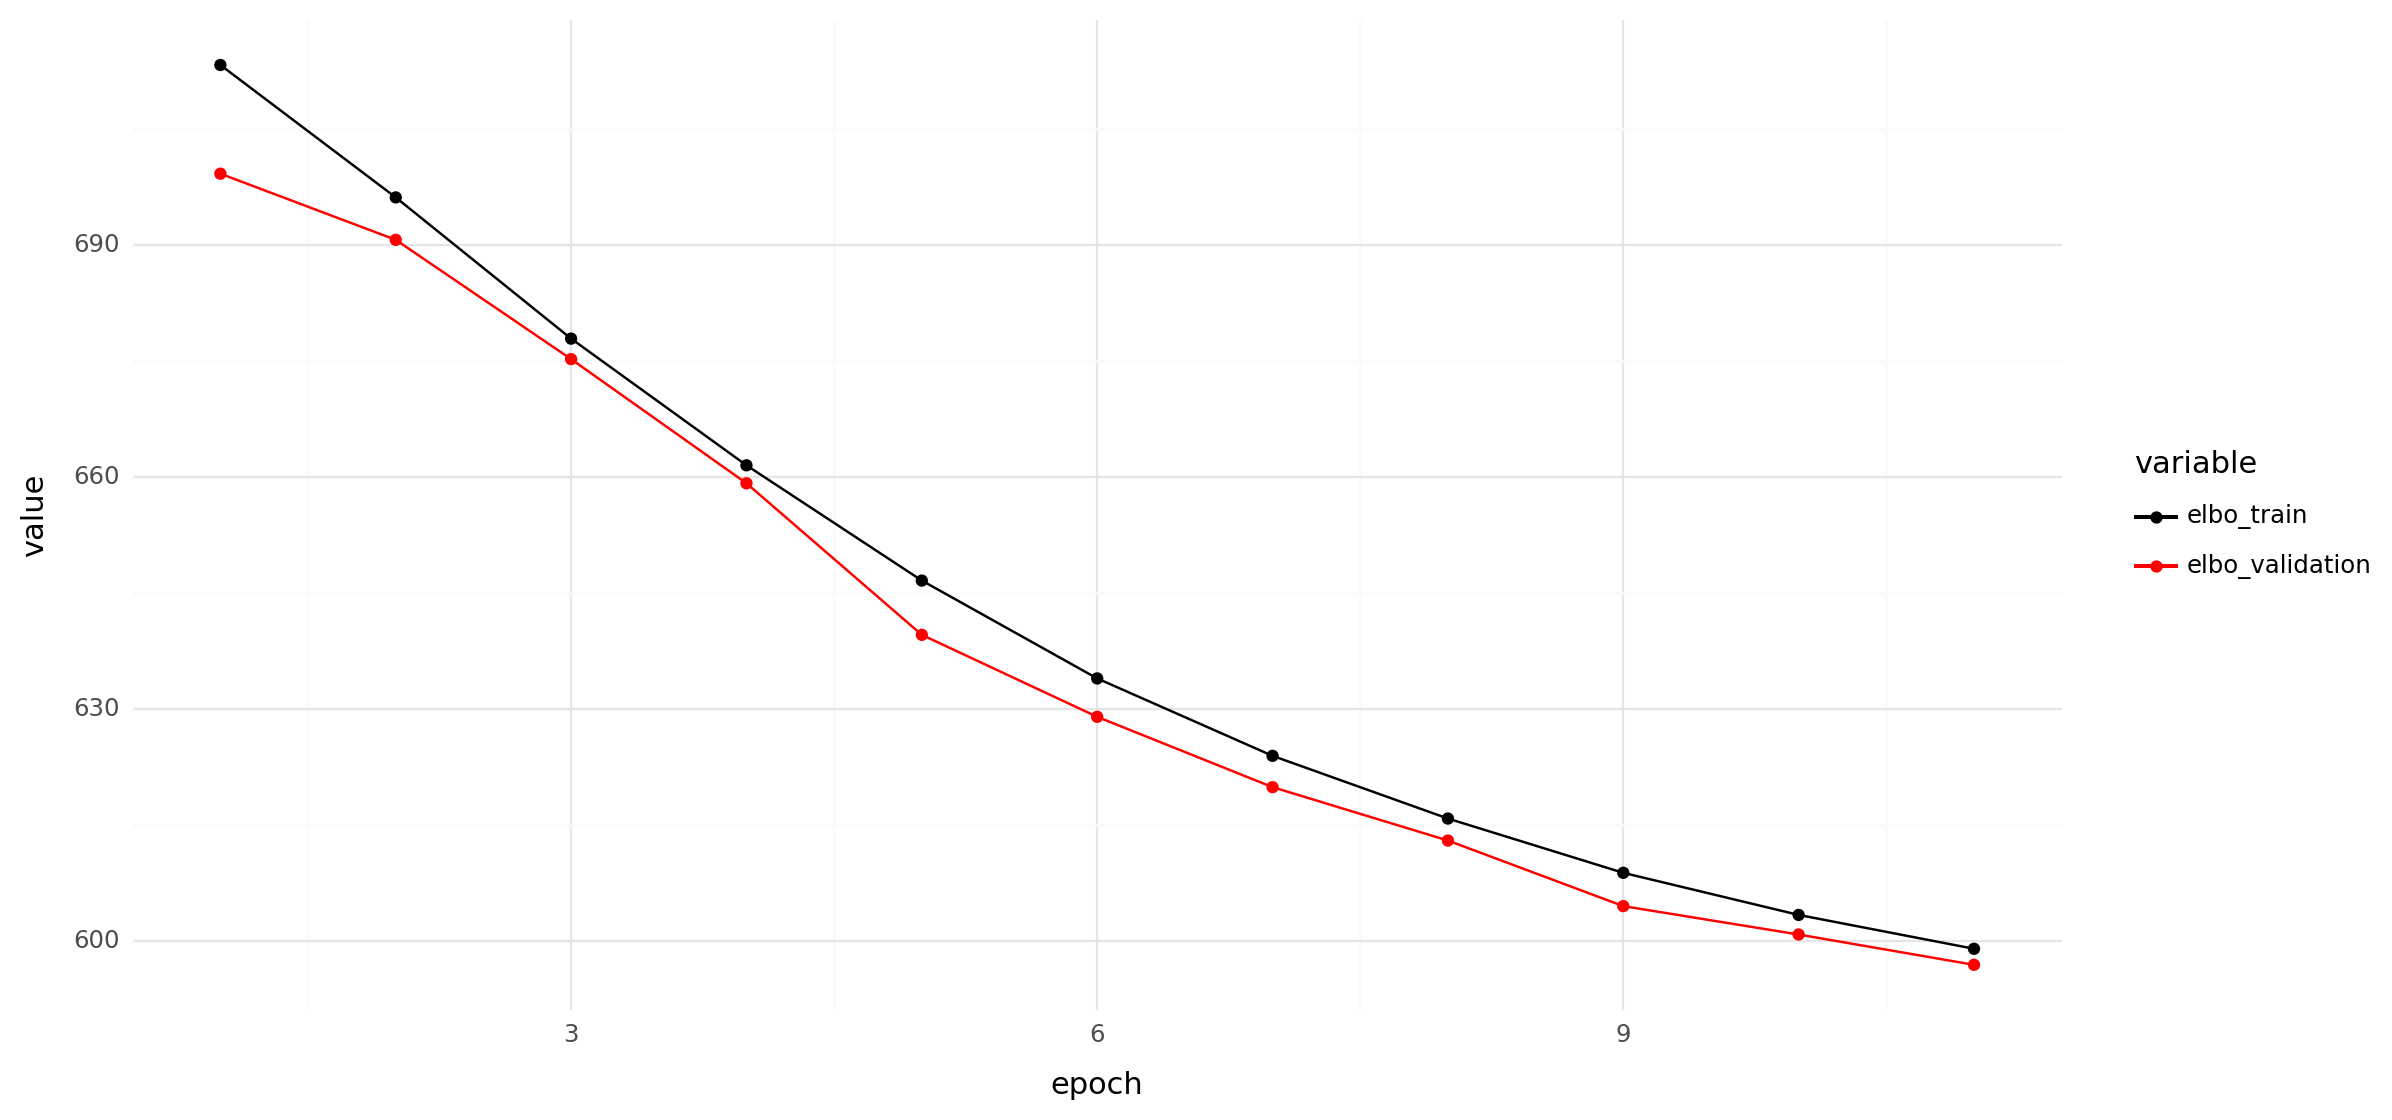

In [34]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [35]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [36]:
scanvi_model.train(20, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [1]                            
)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 20/20: 100%|██████████| 20/20 [03:11<00:00, 10.19s/it, v_num=1, train_loss_step=564, train_loss_epoch=554]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [03:11<00:00,  9.59s/it, v_num=1, train_loss_step=564, train_loss_epoch=554]


### Evaluate model performance a la Svensson

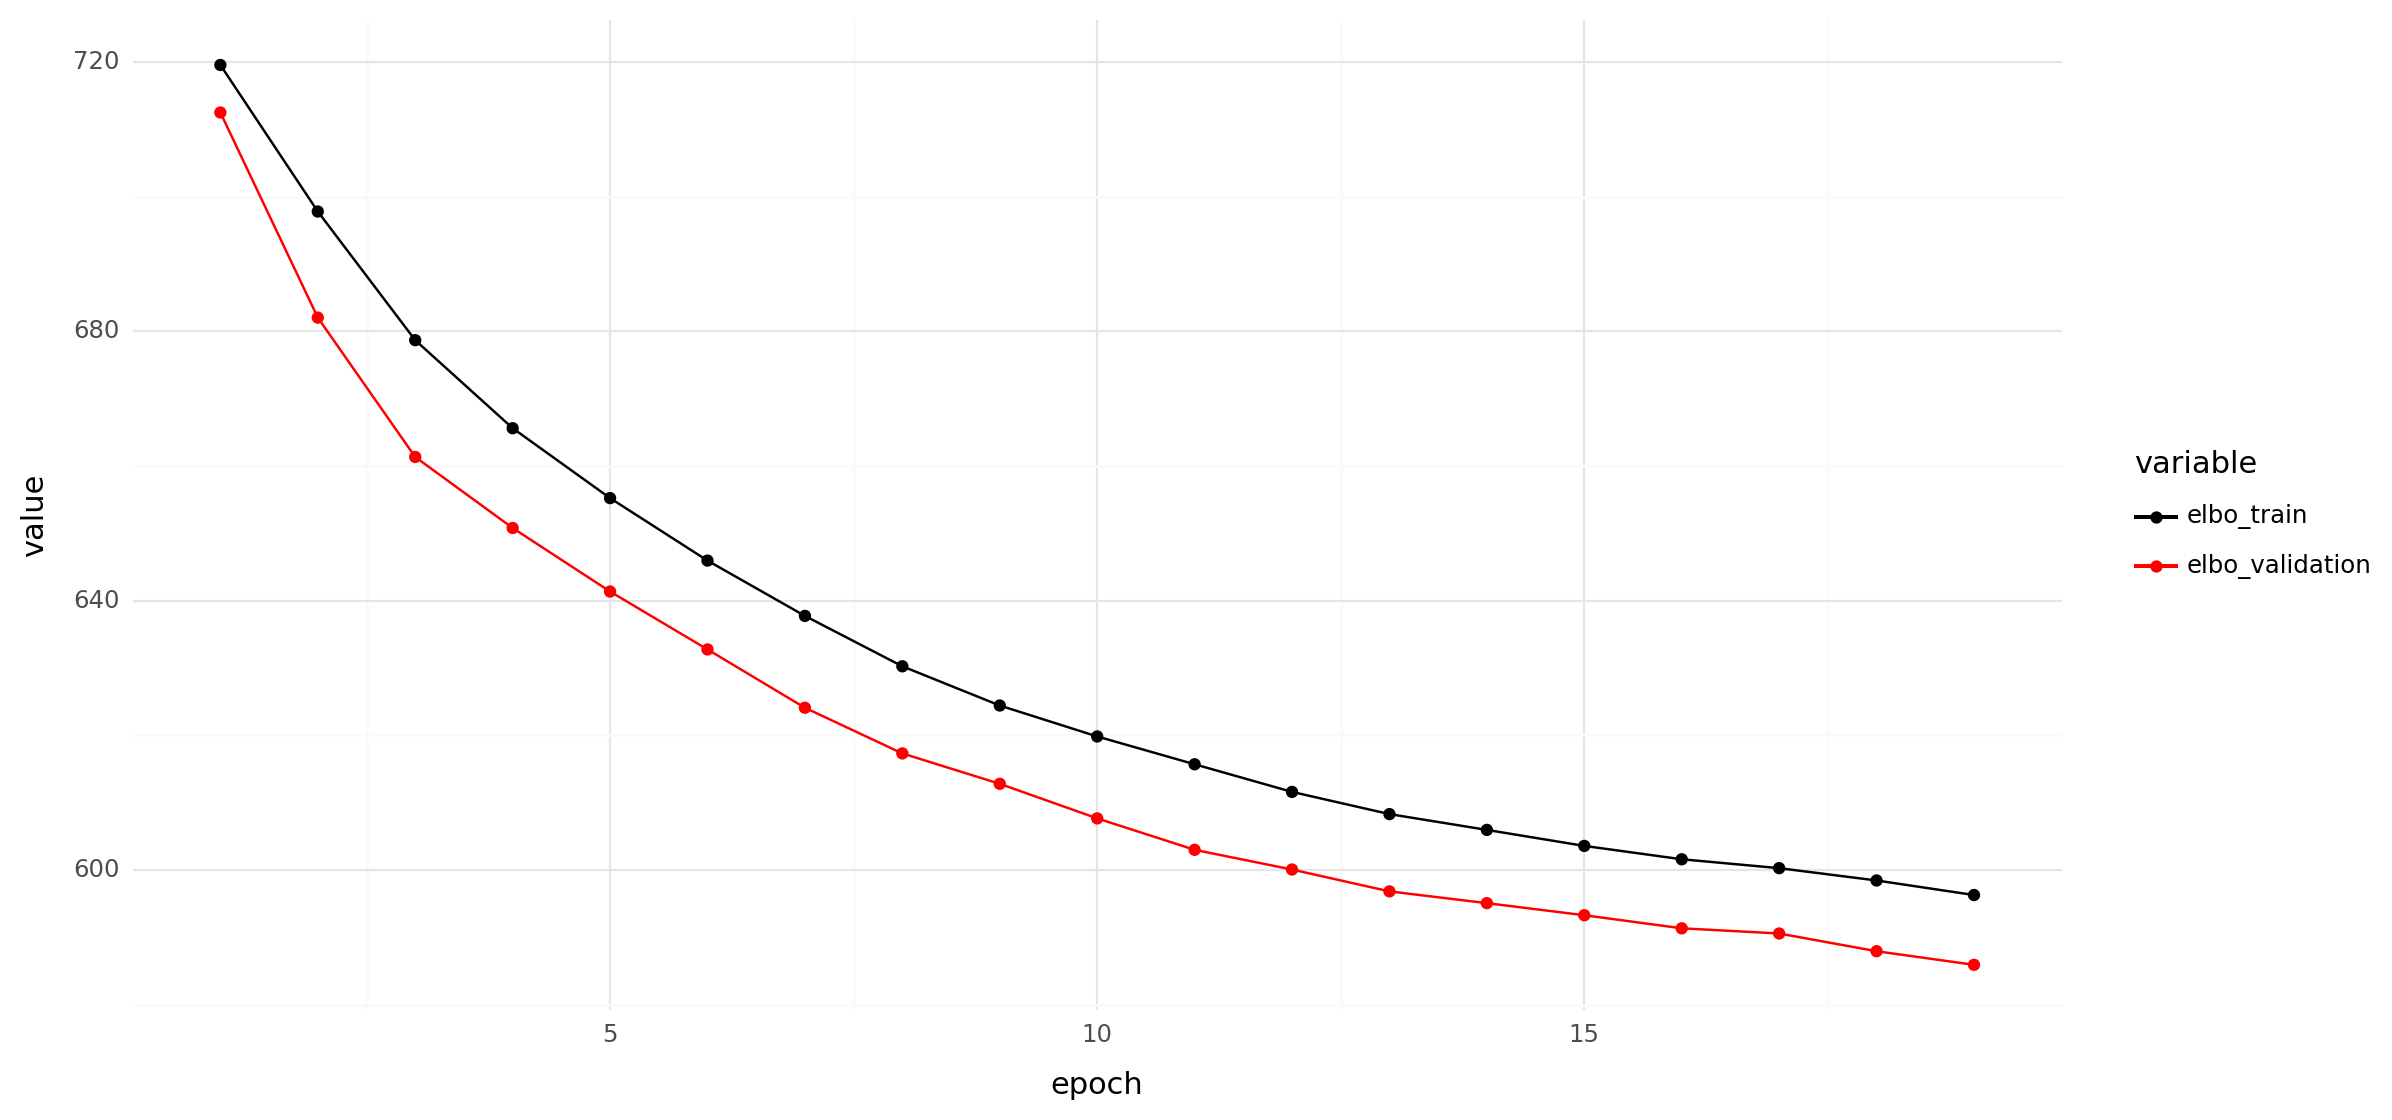

In [37]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig2.png', dpi = 300)

print(p_)

In [38]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [39]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [40]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:43)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:50)


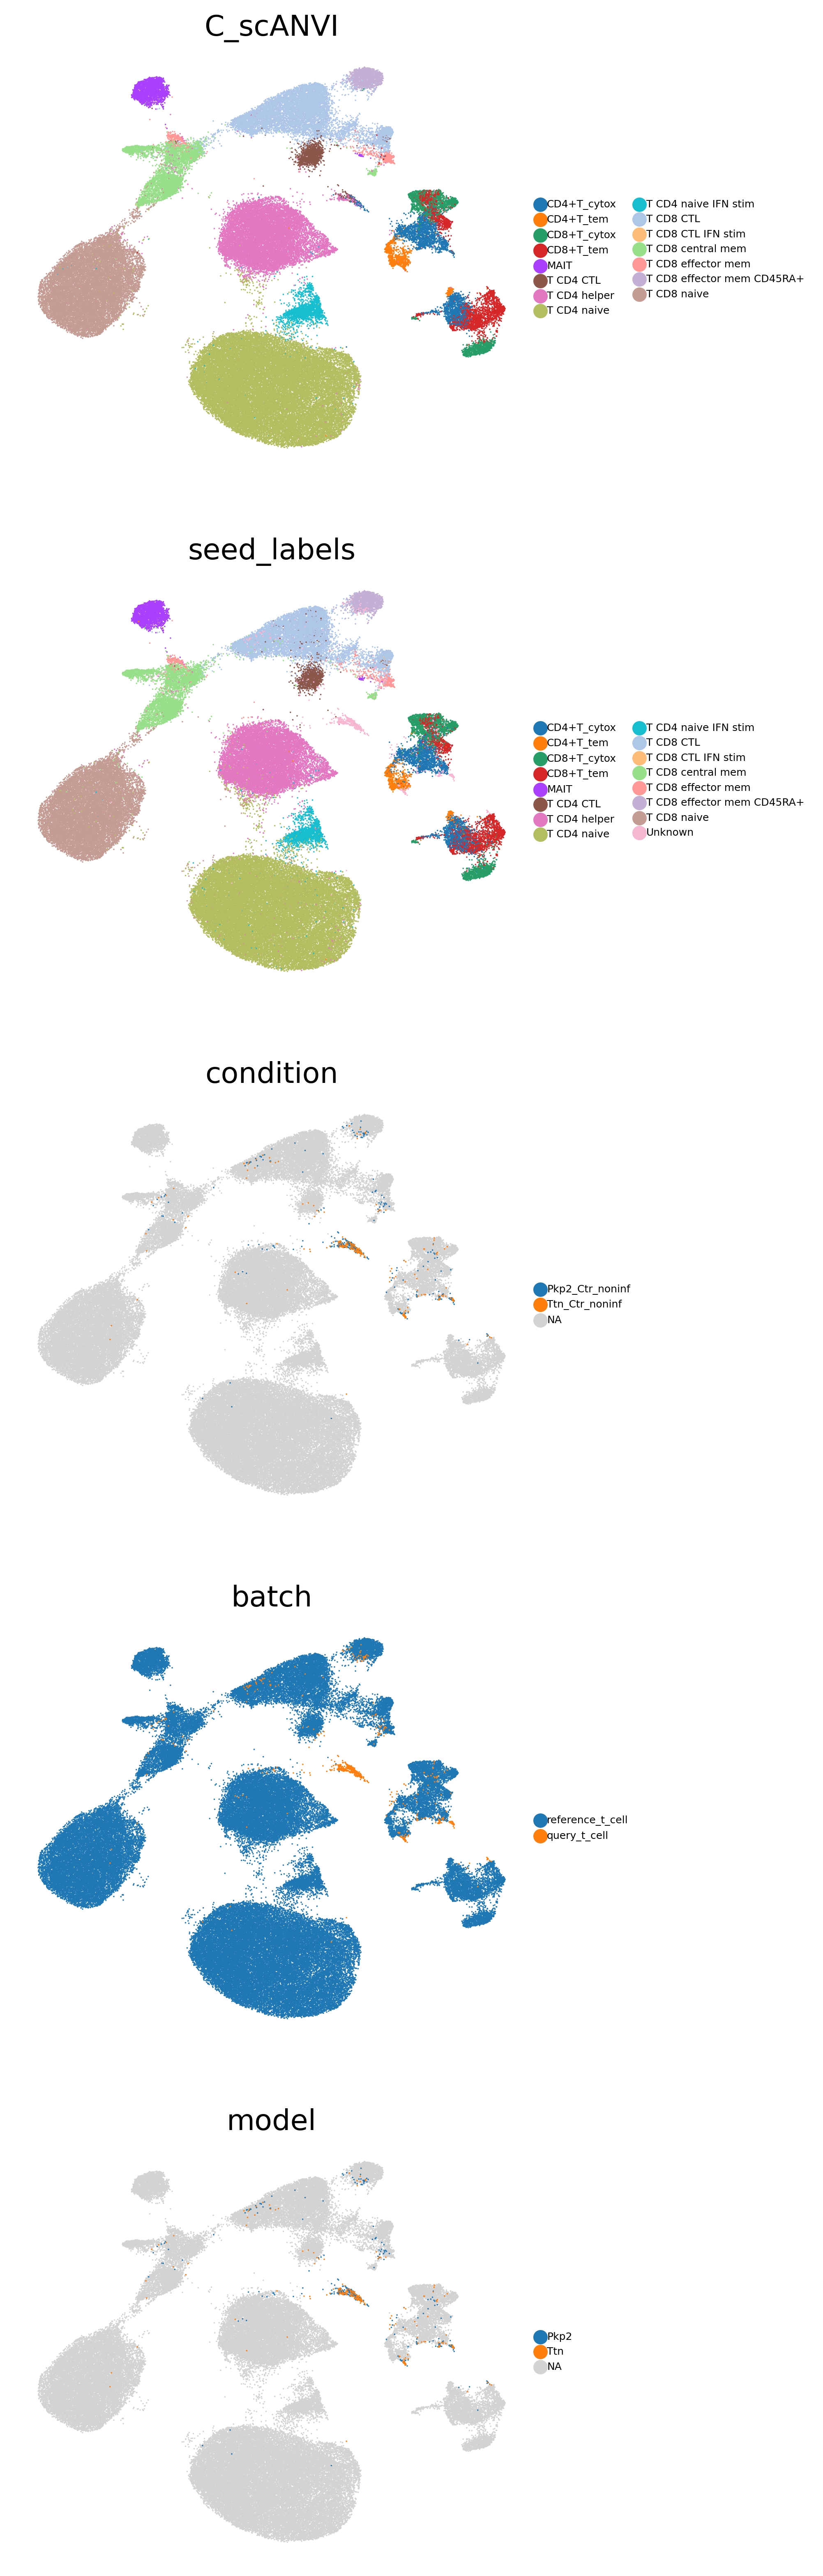

In [41]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'condition', 'batch', 'model'], size = 2, legend_fontsize = 5, ncols = 1)

### Export annotated object

In [42]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)                    #export a merged AnnData object with raw values from X and raw genes but modified observations
adata_export_merged

AnnData object with n_obs × n_vars = 96337 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query_t_cell', 'feature_types-query_t_cell', 'mt-query_t_cell', 'ribo-query_t_cell', 'n_cells_by_counts-A1-query_t_cell', 'mean_counts-A1-query_t_cell', 'pct_dropout_by_counts-A1-query_t_cell', 'total_counts-A1-query_t_cell', 'n_cells_by_counts-A2-query_t_cell', 'mean_counts-A2-query_t_cell', 'pct_dropout_by_counts-A2-query_t_cell', 'total_counts-A2-query_t_cell', 'n_

In [43]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query_t_cell'])]                     #subset merged data set to keep only query
adata_export

View of AnnData object with n_obs × n_vars = 702 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query_t_cell', 'feature_types-query_t_cell', 'mt-query_t_cell', 'ribo-query_t_cell', 'n_cells_by_counts-A1-query_t_cell', 'mean_counts-A1-query_t_cell', 'pct_dropout_by_counts-A1-query_t_cell', 'total_counts-A1-query_t_cell', 'n_cells_by_counts-A2-query_t_cell', 'mean_counts-A2-query_t_cell', 'pct_dropout_by_counts-A2-query_t_cell', 'total_counts-A2-query_t_cell

### Add new gene symbols

In [44]:
query_export = anndata.AnnData(X = query_t_cell.X, var = query_t_cell.var, obs = adata_export.obs)            #make sure to store the raw X values and the raw genes together with modified observations
query_export

AnnData object with n_obs × n_vars = 702 × 32285
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 't

### Revert gene symbols

In [45]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]                     #restore mouse gene nomenclature
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'Ac163611.1', 'Ac163611.2', 'Ac140365.1', 'Ac124606.2',
       'Ac124606.1', 'Ac133095.2', 'Ac133095.1', 'Ac234645.1', 'Ac149090.1'],
      dtype='object', length=32285)

In [46]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
CD4+T_cytox                   210
T CD4 helper                  154
T CD4 CTL                     110
CD4+T_tem                      60
T CD8 CTL                      56
T CD8 effector mem CD45RA+     36
CD8+T_tem                      23
CD8+T_cytox                    20
T CD8 central mem              19
T CD8 effector mem              6
T CD4 naive                     4
T CD8 naive                     3
MAIT                            1
Name: count, dtype: int64

In [47]:
query_export

AnnData object with n_obs × n_vars = 702 × 32285
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 't

In [48]:
X_is_raw(query_export)

True

In [49]:
#Clean up metadata - delete all columns that came from merging with reference data set

del(query_export.obs["COVID_status"])
del(query_export.obs["annotation_broad"])
del(query_export.obs["annotation_detailed"])
del(query_export.obs['age_group'])
del(query_export.obs['cell_states'])
del(query_export.obs['gender'])
del(query_export.obs['NRP'])
del(query_export.obs['region'])
del(query_export.obs['scNym'])
del(query_export.obs['scNym_confidence'])
del(query_export.obs['seed_annotation_general'])

In [50]:
query_export.obs

,n_counts,n_genes,donor,sample,cell_source,seed_labels,condition,genotype,infection,library,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAACCCAAGATACAGT-1-A1-query-query_t_cell,8562.0,2769,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,23.662696,0.019038,0.000000,0.0,-0.339369,-0.496060,query_t_cell,50,15,CD4+T_cytox
AACCCAATCAGCTGAT-1-A1-query-query_t_cell,14129.0,3741,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,22.867860,0.019817,0.021233,0.0,0.525671,-0.137838,query_t_cell,49,15,T CD8 CTL
AACGTCAAGCTACTGT-1-A1-query-query_t_cell,2057.0,1147,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,1.895965,0.074866,0.194458,0.0,-0.270605,-0.340320,query_t_cell,50,15,CD4+T_cytox
AACTTCTCAAGCGCTC-1-A1-query-query_t_cell,9940.0,2786,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,29.668008,0.022233,0.000000,0.0,-0.414867,-0.271517,query_t_cell,50,15,CD4+T_cytox
AAGCCATTCCACAGGC-1-A1-query-query_t_cell,3609.0,1574,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,1.163757,0.049598,0.083126,0.0,0.102686,-0.498646,query_t_cell,50,15,CD4+T_cytox
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCTTCCAGCTACGTT-1-B2-query-query_t_cell,11828.0,3341,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,23.698005,0.022827,0.016909,0.0,-0.189553,-0.596913,query_t_cell,54,15,T CD4 CTL
TTGTGGAGTATTGAGA-1-B2-query-query_t_cell,2299.0,1251,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,2.914311,0.058286,0.130492,0.0,-0.117061,-0.443566,query_t_cell,54,15,T CD4 CTL
TTGTTCAGTGGCAGAT-1-B2-query-query_t_cell,6256.0,2130,Ttn_Ctr_noninf_1,Ttn_Ctr_noninf_1,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,29.395780,0.025575,0.015985,0.0,0.373745,-0.350468,query_t_cell,53,15,T CD8 CTL
TTTACTGAGTGTTCCA-1-B2-query-query_t_cell,2371.0,1268,Ttn_Ctr_noninf_1,Ttn_Ctr_noninf_1,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,2.193167,0.035428,0.210881,0.0,0.327349,-0.098295,query_t_cell,53,15,CD4+T_cytox


In [51]:
query_export.write('/home/acirnu/data/ACM_cardiac_leuco/processed_merged/T-cells_from_Ctrls_with_scANVI_cellstates_from_healthy_reference_ac240223.raw.h5ad')